<a href="https://colab.research.google.com/github/criswada/Lovelace/blob/master/Modelo_Regress%C3%A3o_Gr%C3%A3_Bretanha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset GR√É-BRETANHA**

In [0]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import statsmodels.discrete.discrete_model as sm



from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [6]:
df_GB = pd.read_csv('GBvideos.csv', delimiter=',')
df_GB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null object
title                     38916 non-null object
channel_title             38916 non-null object
category_id               38916 non-null int64
publish_time              38916 non-null object
tags                      38916 non-null object
views                     38916 non-null int64
likes                     38916 non-null int64
dislikes                  38916 non-null int64
comment_count             38916 non-null int64
thumbnail_link            38916 non-null object
comments_disabled         38916 non-null bool
ratings_disabled          38916 non-null bool
video_error_or_removed    38916 non-null bool
description               38304 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.0+ MB


In [45]:
df_GB.views.median()

981889.0

## Target


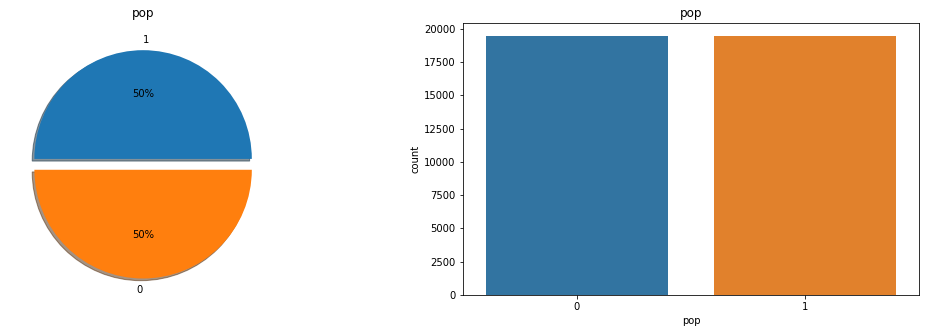

In [46]:
# Target identify 

df_GB['pop'] = 0
df_GB.loc[df_GB.views >= 981889.0, ['pop']] = 1

f,ax=plt.subplots(1,2,figsize=(18,5))
df_GB['pop'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.f%%',ax=ax[0],shadow=True)
ax[0].set_title('pop')
ax[0].set_ylabel('')
sns.countplot('pop',data=df_GB,ax=ax[1])
ax[1].set_title('pop')
plt.show()

## Tratamento do DataFrame


In [47]:
df_GB.head().T

0  ...                                                  4
video_id                                                      Jw1Y-zhQURU  ...                                        rHwDegptbI4
trending_date                                                    17.14.11  ...                                           17.14.11
title                       John Lewis Christmas Ad 2017 - #MozTheMonster  ...  Dashcam captures truck's near miss with child ...
channel_title                                                  John Lewis  ...                                   Cute Girl Videos
category_id                                                            26  ...                                                 25
publish_time                                     2017-11-10T07:38:29.000Z  ...                           2017-11-13T01:45:13.000Z
tags                    christmas|"john lewis christmas"|"john lewis"|...  ...                                             [none]
views                                                             7224515  ...                                               9815
likes                                                               55681  ...                                                 30
dislikes                                                            10247  ...                                                  2
comment_count                                                        9479  ...                                                 30
thumbnail_link             https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg  ...     https://i.ytimg.com/vi/rHwDegptbI4/default.jpg
comments_disabled                                                   False  ...                                              False
ratings_disabled                                                    False  ...                                              False
video_error_or_removed                                              False  ...                                              False
description             Click here to continue the story and make your...  ...  Dashcam captures truck's near miss with child ...
pop                                                                     1  ...                                                  0
category_name                                               Howto & Style  ...                                    News & Politics

[18 rows x 5 columns]

In [0]:
#Fazendo uma c√≥pia do Dataframe
df_GB = df_GB.copy()

In [25]:
df_GB.describe()

category_id         views  ...  comment_count           pop
count  38916.000000  3.891600e+04  ...   3.891600e+04  38916.000000
mean      16.827937  5.911944e+06  ...   1.308835e+04      0.123985
std        7.752728  1.900121e+07  ...   5.066740e+04      0.329569
min        1.000000  8.510000e+02  ...   0.000000e+00      0.000000
25%       10.000000  2.515272e+05  ...   6.790000e+02      0.000000
50%       20.000000  9.818890e+05  ...   2.478000e+03      0.000000
75%       24.000000  3.683628e+06  ...   9.241500e+03      0.000000
max       43.000000  4.245389e+08  ...   1.626501e+06      1.000000

[8 rows x 6 columns]

In [49]:
#Importando o json para ver a category_id
import json

with open('GB_category_id.json', 'r') as f:
  categ_gb = json.load(f)

for k in categ_gb['items']:
  print(k['id'], k['snippet']['title'])

1 Film & Animation
2 Autos & Vehicles
10 Music
15 Pets & Animals
17 Sports
18 Short Movies
19 Travel & Events
20 Gaming
21 Videoblogging
22 People & Blogs
23 Comedy
24 Entertainment
25 News & Politics
26 Howto & Style
27 Education
28 Science & Technology
30 Movies
31 Anime/Animation
32 Action/Adventure
33 Classics
34 Comedy
35 Documentary
36 Drama
37 Family
38 Foreign
39 Horror
40 Sci-Fi/Fantasy
41 Thriller
42 Shorts
43 Shows
44 Trailers


In [0]:
#Analisando a quantidade de categorias 

import json

# open json file with category names
with open('GB_category_id.json', 'r') as f:
  categ_us = json.load(f)

categ_dic = {}

for k in categ_us['items']:
  categ_dic[k['id']]= k['snippet']['title']

#print(categ_dic)

# Creating new column with category names
temp = df_GB.category_id.copy()
temp = temp.astype('str')
df_GB['category_name'] = temp.map(categ_dic)

#print(df.loc[:10, ['category_id', 'category_name']])

Text(0, 0.5, 'Category')

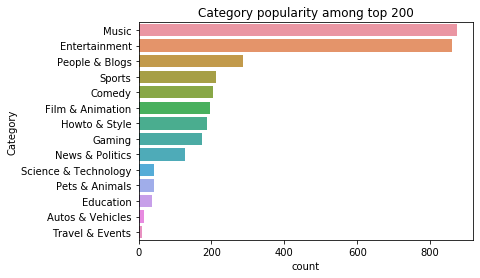

In [51]:
df_GB2 = df_GB.copy()
df_GB2.drop_duplicates('video_id', inplace=True)
sns.countplot(y='category_name', data=df_GB2, order=df_GB2.category_name.value_counts().index )
plt.title('Category popularity among top 200')
plt.ylabel('Category')

In [52]:
df_GB2.groupby('category_name')['views'].sum().sort_values()

category_name
Travel & Events            4434990
Autos & Vehicles           8987658
Education                 11904956
Pets & Animals            14972620
Science & Technology      46400839
Howto & Style             53169625
News & Politics           54162901
Gaming                    87607019
Sports                   116728796
People & Blogs           159612182
Film & Animation         189889886
Comedy                   199914569
Entertainment            931136760
Music                   2340066368
Name: views, dtype: int64

### Outliers

In [0]:
#Fun√ß√£o para detectar os outliers do novo DataFrame

def detect_outliers(df_GB2,n,features):
    outlier_indices = []
    
    for col in features:

        Q1 = np.percentile(df_GB2[col], 25)
        Q3 = np.percentile(df_GB2[col],75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        outlier_list_col = df_GB2[(df_GB2[col] < Q1 - outlier_step) | (df_GB2[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [0]:
Outliers_to_drop = detect_outliers(df_GB2,1,['views', 'likes', 'dislikes', 'comment_count'])

In [55]:
df_GB2.loc[Outliers_to_drop]

video_id trending_date  ... pop    category_name
0      Jw1Y-zhQURU      17.14.11  ...   1    Howto & Style
2      n1WpP7iowLc      17.14.11  ...   1            Music
6      2Vv-BfVoq4g      17.14.11  ...   1            Music
9      9t9u_yPEidY      17.14.11  ...   1            Music
17     pz95u3UVpaM      17.14.11  ...   1            Music
...            ...           ...  ...  ..              ...
33809  r17fqELkv7g      18.15.05  ...   1    Entertainment
35271  zCot9TDoA-M      18.24.05  ...   1           Gaming
35435  wswvNZveNHc      18.25.05  ...   1    Entertainment
35921  Ut7e-0X8lds      18.28.05  ...   1  News & Politics
38588  1zNr8Pf1QkY      18.13.06  ...   1  News & Politics

[476 rows x 18 columns]

In [0]:
#Deletando os Outliers encontrados
df_GB2 = df_GB2.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [57]:
#Percentual dos valores nulos
percent_missing = round(df_GB2.isnull().sum() * 100 / len(df_GB2),2)
missing_value_df = pd.DataFrame({'column_name': df_GB2.columns, 'percent_missing': percent_missing})
missing_value_df = missing_value_df[missing_value_df['percent_missing'] > 0]
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

column_name  percent_missing
description      description             1.93
category_name  category_name             0.18

In [0]:
#Substituindo os valores na da coluna description e category_name por'Missing' 
df_GB2.description.fillna('Missing', inplace=True)
df_GB2.category_name.fillna('Missing', inplace=True)

In [59]:
# Detectando Valores nulos
df_GB2.isnull().sum()/ len(df_GB2) * 100

video_id                  0.0
trending_date             0.0
title                     0.0
channel_title             0.0
category_id               0.0
publish_time              0.0
tags                      0.0
views                     0.0
likes                     0.0
dislikes                  0.0
comment_count             0.0
thumbnail_link            0.0
comments_disabled         0.0
ratings_disabled          0.0
video_error_or_removed    0.0
description               0.0
pop                       0.0
category_name             0.0
dtype: float64

Text(0, 0.5, 'category_id')

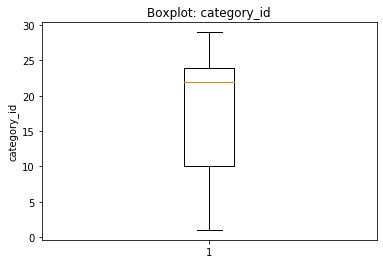

In [60]:
# Bloxpot feature 'category_id'
plt.boxplot(df_GB2['category_id'])
plt.title('Boxplot: category_id')
plt.ylabel('category_id')

### An√°lise e Visualiza√ß√£o

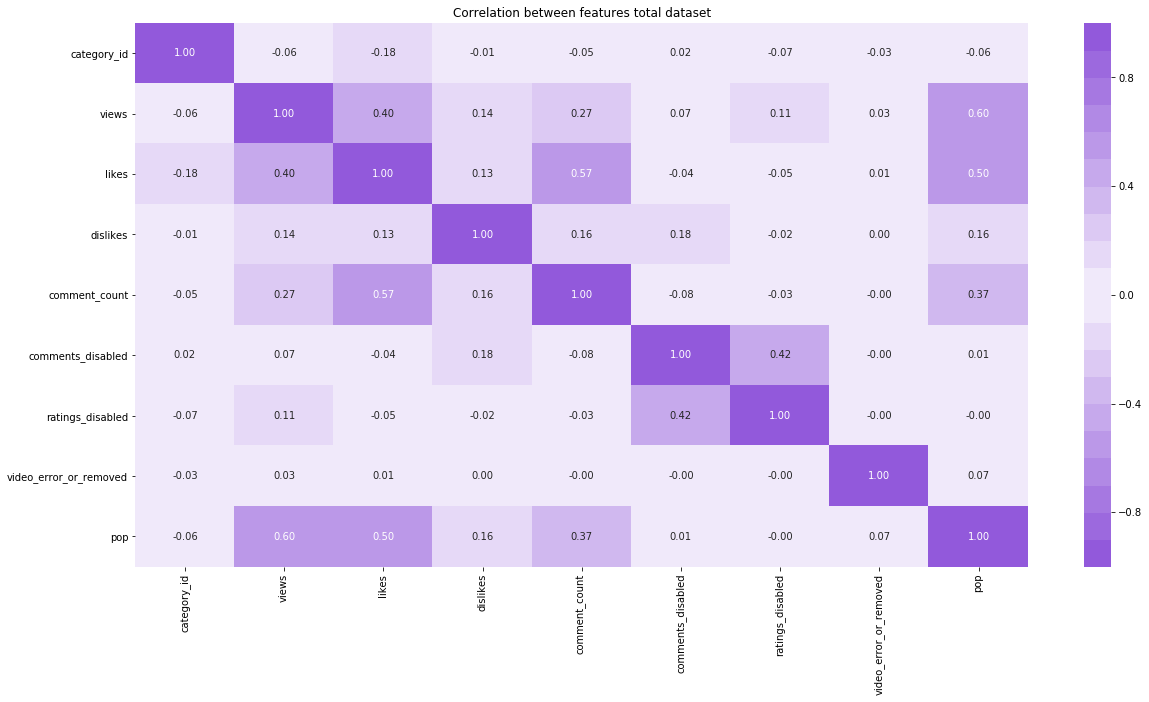

In [61]:
#Correla√ß√£o de todas as vari√°veis

plt.figure(figsize=[20,10])
plt.title('Correlation between features total dataset')
sns.heatmap(df_GB2.corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap=sns.diverging_palette(999, 999, n=20))
plt.show()

### Modelando

In [62]:
#Deletando as colunas "genero" e "des_email"
train_bkp = df_GB2.copy()
df_GB2.drop(['video_id', 'trending_date', 'title', 'channel_title', 'publish_time', 'tags', 'thumbnail_link', 'description', 'category_name', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed' ],axis=1,inplace=True)
df_GB2.head()

category_id    views  likes  dislikes  comment_count  pop
0           24  1053632  25561      2294           2757    1
1           17    27833    193        12             37    0
2           25     9815     30         2             30    0
3           24  1182775  52708      1431           2333    1
4           22  1164201  57309       749            624    1

In [0]:
x = df_GB2.drop(columns=['pop']).copy()
y = df_GB2['pop']

In [64]:
#Separando o dataframe em traino e teste
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1957, 5) (1957,)
(839, 5) (839,)


## Feature Importance

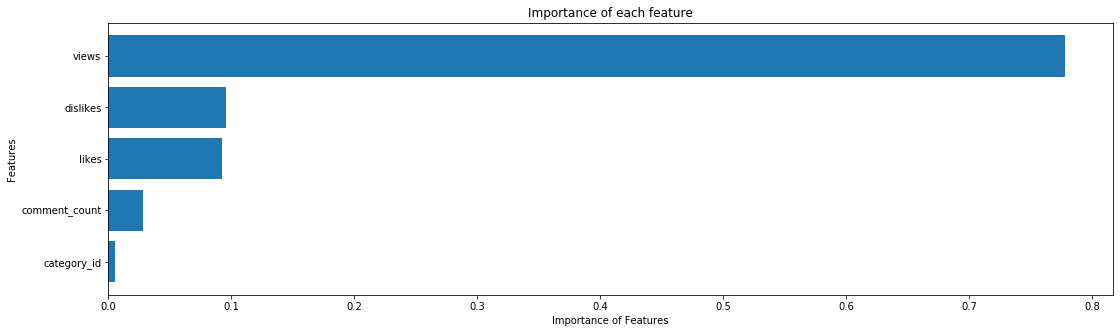

In [65]:
#Constru√ß√£o do Modelo de classifica√ß√£o Random Forest
rfmodel = RandomForestClassifier(random_state=0,n_estimators=450,criterion='gini',n_jobs=-1,max_depth = 8,min_samples_leaf=1,min_samples_split= 11)

#Treinamento do modelo em X_train, Y_train
rfmodel.fit(x_train,y_train)

#Predi√ß√£o do modelo no X_test
y_pred = rfmodel.predict(x_test)
proba = rfmodel.predict_proba(x_test)

#Vari√°veis Importantes
imp = rfmodel.feature_importances_
names = df_GB2.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align = "center")
plt.yticks(range(len(names)), names)
plt.xlabel("Importance of Features")
plt.ylabel("Features")
plt.title("Importance of each feature")
fig=plt.gcf()
fig.set_size_inches(18,5)
plt.show()

In [66]:
a = {'names':names,'imp':imp}
tabela = pd.DataFrame(data=a)
tabela

names       imp
0    category_id  0.005660
1  comment_count  0.028263
2          likes  0.092138
3       dislikes  0.095855
4          views  0.778085

## Cross Validation


In [67]:
#Applying K-Fold Cross Validation
accuracies = cross_val_score(estimator=rfmodel,X= x_train,y=y_train,cv=2)
print(accuracies)
acc_train = accuracies.mean() #Prints out the  average of the 10 scores.
acc_train

[0.99897855 1.        ]


0.9994892747701736

In [69]:
confusion_matrix(y_pred, y_test)

array([[743,   0],
       [  0,  96]])

In [70]:
from sklearn.linear_model import LogisticRegression

rlmodel = LogisticRegression()
rlmodel.fit(x,y)

res = sm.Logit(y, x).fit()

params = res.params
odds = res.conf_int()
odds['OR'] = params
odds.columns = ['2.5%','97.5%','OR']
np.exp(odds).sort_values(by = 'OR', ascending = False).round(2)

Optimization terminated successfully.
         Current function value: 0.190753
         Iterations 9


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2.5%  97.5%    OR
comment_count  1.00   1.00  1.00
views          1.00   1.00  1.00
likes          1.00   1.00  1.00
dislikes       1.00   1.00  1.00
category_id    0.75   0.78  0.76